In [26]:
import numpy as np
import pandas as pd
import itertools
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import get_testloader
import os
import glob
from natsort import natsorted
from cnn import *
from players import *
from game import Game
import random

In [2]:
model_names = [
    "3conv-3fc-bn",
    "5conv-3fc-bn"
]

Plot csv data

In [3]:
csv_data = [] #epoch, loss, and validation accuracy
for m in model_names:
    df = pd.read_csv("models/{}/{}.csv".format(m, m))
    epoch = df["epoch"]
    loss = df["loss"]
    val_acc = df["val_accuracy"]
    csv_data.append([epoch, loss, val_acc])

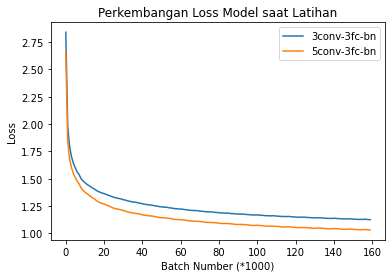

In [4]:
#Loss 
for i, m in enumerate(model_names):
    plt.plot(csv_data[i][1], label=m)

plt.title("Perkembangan Loss Model saat Latihan")
plt.ylabel("Loss")
plt.xlabel("Batch Number (*1000)")
plt.legend()
plt.show()

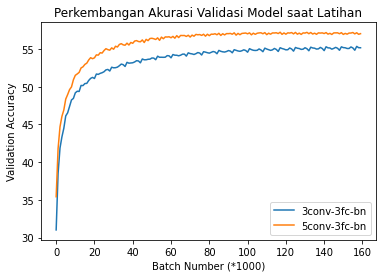

In [5]:
#Val_accuracy
for i, m in enumerate(model_names):
    plt.plot(csv_data[i][2], label=m)

plt.title("Perkembangan Akurasi Validasi Model saat Latihan")
plt.ylabel("Validation Accuracy")
plt.xlabel("Batch Number (*1000)")
plt.legend()
plt.show()

Plot test accuracy for each model

In [17]:
#Load data
testloader = torch.load("dataset/testloader.pth")

In [18]:
model_test_accuracy = []
for m in model_names:
    if m=="3conv-3fc-bn":
        net = CNN3Conv()
    elif m=="5conv-3fc-bn":
        net = CNN5Conv()
    net.load("models/{}/{}-epoch-19.pth".format(m, m))
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()
    print("{}-Test accuracy : {}%".format(m, 100*correct/total))
    model_test_accuracy.append(100*correct/total)

3conv-3fc-bn-Test accuracy : 57.250376572567774%
5conv-3fc-bn-Test accuracy : 59.31968919944054%


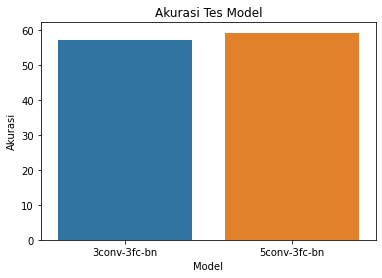

In [87]:
#Test accuracy
sns.barplot(x=model_names, y=model_test_accuracy)
plt.title("Akurasi Tes Model")
plt.ylabel("Akurasi")
plt.xlabel("Model")
plt.show()

Evaluate model performance against other agents

In [53]:
def play_vs_agent(player, match_size=100, opponent="random", randomize_start=False):
    if opponent=="random":
        o = RandomPlayer()
    elif opponent=="positional":
        o = PositionalPlayer()
    elif opponent=="mobility":
        o = MobilityPlayer()
    player_wins = 0

    for _ in range(match_size):
        # Initialize a new game
        g = Game(8, randomize_start=randomize_start)
        
        # Randomise the player order
        random_number = random.random()
        if random_number > 0.5:
            g.addPlayer(player, False)
            g.addPlayer(o, False)
            player_order = 0
            if randomize_start:
                player_order = 1
        else :
            g.addPlayer(o, False)
            g.addPlayer(player, False)
            player_order = 1
            if randomize_start:
                player_order = 0
        g.run()

        final_score = list(g.getScore().items())
        final_score.sort()
        ttl = sum(map(lambda x: x[1], final_score))
        #player_score = int(final_score[0][1]/ttl >= 0.5)
        player_score =  (final_score[player_order][1]/ttl - 0.5)*2
        player_wins += player_score > 0

    return player_wins/match_size


In [38]:
#winning rate againts mobility agent for each epoch
model_winrates = []
for m in model_names:
    epoch_files = []
    for file in glob.glob("models/{}/*.pth".format(m)):
        epoch_files.append(file)
    epoch_files = natsorted(epoch_files)

    epoch_winrates = []
    for i, e in enumerate(epoch_files):
        if m=="3conv-3fc-bn":
            arch = "3Conv"
        elif m=="5conv-3fc-bn":
            arch = "5Conv"
        player = CNNPlayer(e, arch=arch)
        winrate = play_vs_agent(player, opponent="mobility")
        epoch_winrates.append(winrate)
        # print("{}-{}-winrate : {}".format(m, i, winrate))

    model_winrates.append(epoch_winrates)

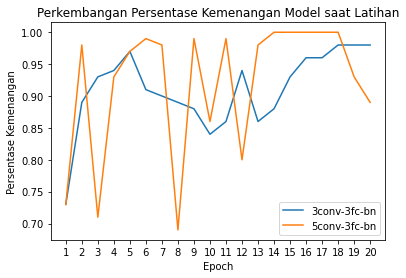

In [40]:
#Winrates
for i, m in enumerate(model_names):
    plt.plot(model_winrates[i], label=m)

plt.title("Perkembangan Persentase Kemenangan Model saat Latihan")
plt.ylabel("Persentase Kemenangan")
plt.xlabel("Epoch")
plt.xticks(np.arange(20), np.arange(1, 21))
plt.legend()
plt.show()

In [78]:
agent_winrates = []
for m in model_names:
    path = "models/{}/{}-epoch-19.pth".format(m, m)
    if m=="3conv-3fc-bn":
        arch = "3Conv"
    elif m=="5conv-3fc-bn":
        arch = "5Conv"
    player = CNNPlayer(path, arch=arch)
    random_score = play_vs_agent(player, opponent="random", randomize_start=True)
    positional_score = play_vs_agent(player, opponent="positional", randomize_start=True)
    mobility_score = play_vs_agent(player, opponent="mobility", randomize_start=True)
    agent_winrates.append([random_score, positional_score, mobility_score])

In [88]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

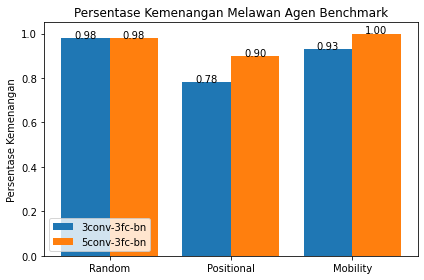

In [89]:
labels = ["Random", "Positional", "Mobility"]

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots()
# rects = []
# for i, m in enumerate(model_names):
    # rects.append(ax.bar(x - width/2, agent_winrates[i], width, label=m))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Persentase Kemenangan')
ax.set_title('Persentase Kemenangan Melawan Agen Benchmark')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.bar(x-0.2, agent_winrates[0], width, label=model_names[0])
plt.bar(x+0.2, agent_winrates[1], width, label=model_names[1])
ax.legend(loc="lower left")

show_values_on_bars(ax)

fig.tight_layout()

plt.show()